# A Notebook Used to Train A Pest Classification Model

> Dataset: Pest Detection Dataset From Kaggle:
>> This dataset contains 12 different classes of crop pest

In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
data_dir = '/content/drive/MyDrive/Colab_Notebooks/pest_classification/Pest_Dataset'

In [3]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from pathlib import Path
import os.path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_hub as tf_hub

# Data Visualization

In [ ]:
len(os.listdir(data_dir))

12

In [9]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(data_dir)

In [10]:
image_df.head()

,Filepath,Label
0,/content/drive/MyDrive/Colab_Notebooks/pest_cl...,beetle
1,/content/drive/MyDrive/Colab_Notebooks/pest_cl...,beetle
2,/content/drive/MyDrive/Colab_Notebooks/pest_cl...,beetle
3,/content/drive/MyDrive/Colab_Notebooks/pest_cl...,beetle
4,/content/drive/MyDrive/Colab_Notebooks/pest_cl...,beetle


In [11]:
# To check for any corrupted image
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path('/content/drive/MyDrive/Colab_Notebooks/pest_classification/Pest_Dataset/beetle').rglob('*.jpg')

for img_p in path:
  try:
        img = PIL.Image.open(img_p)
  except PIL.UnidentifiedImageError:
        print(img_p)

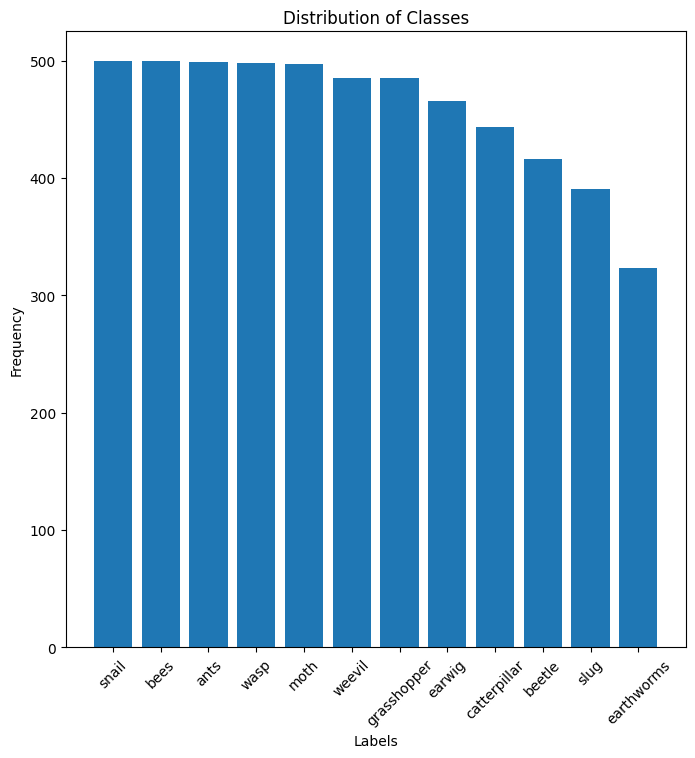

In [12]:
# Visulaize the label distributions
label_count = image_df['Label'].value_counts()

plt.figure(figsize=(8, 8))
plt.bar(x=label_count.index, height=label_count.values)
plt.title('Distribution of Classes')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

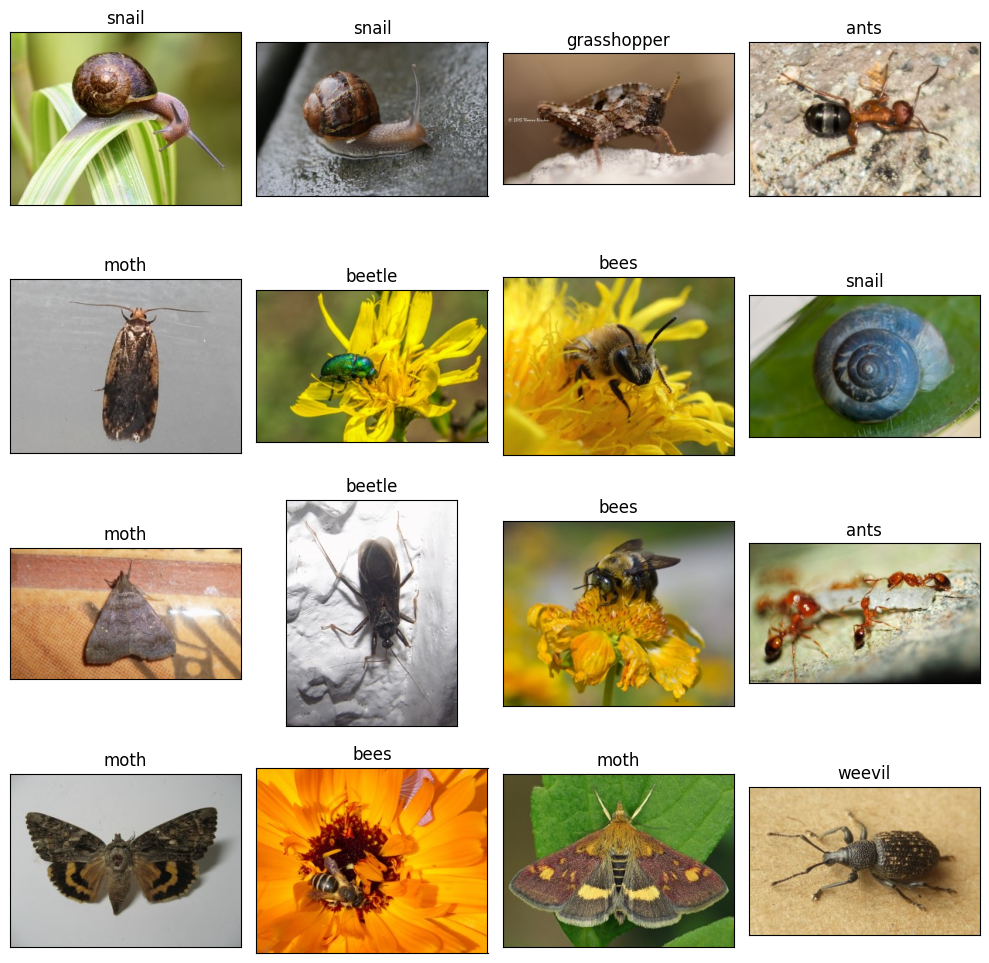

In [13]:
# Visualize random images
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks' : [], 'yticks' : []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [14]:
# Split Images into Train and Test Set
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True)
train_df.shape, test_df.shape

((4403, 2), (1101, 2))

In [15]:
# Create ImageDataGenerator
Train_Data_Gen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split = 0.2,
    horizontal_flip=True,
    vertical_flip=True
)

Test_Data_Gen = tf.keras.preprocessing.image.ImageDataGenerator()

In [16]:
train_data = Train_Data_Gen.flow_from_dataframe(dataframe=train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                          class_mode='categorical',
                                          color='rgb',
                                          shuffle=True,
                                          subset='training',
                                          batch_size=32)

val_data = Train_Data_Gen.flow_from_dataframe(dataframe=train_df,
                                        x_col='Filepath',
                                        y_col='Label',
                                        class_mode='categorical',
                                        color='rgb',
                                        shuffle=True,
                                        subset='validation',
                                        batch_size=32)

test_images = Test_Data_Gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3523 validated image filenames belonging to 12 classes.
Found 880 validated image filenames belonging to 12 classes.
Found 1101 validated image filenames belonging to 12 classes.


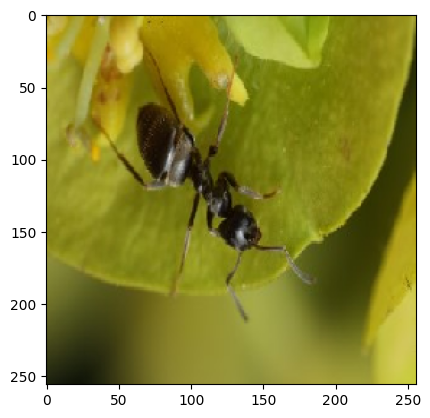

In [17]:
import random
images, labels = train_data.next()
images_ = images[random.randrange(0, 32)].astype('uint8')
plt.imshow(images_)

In [72]:
train_data.class_indices

{'ants': 0,
 'bees': 1,
 'beetle': 2,
 'catterpillar': 3,
 'earthworms': 4,
 'earwig': 5,
 'grasshopper': 6,
 'moth': 7,
 'slug': 8,
 'snail': 9,
 'wasp': 10,
 'weevil': 11}

## Training Model

In [48]:
_num_classes = 12
_batch_size  = 32
_epochs = 15

In [50]:
inputs_layer= tf.keras.layers.Input(shape=(None, None, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(inputs_layer)
x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(x)
x = tf_hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5", trainable=False)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(_num_classes, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs=inputs_layer, outputs=outputs)

In [51]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing_5 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer_5 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_13 (Dense)            (None, 128)               128256    
                                                                 
 dense_14 (Dense)            (None, 256)               33024     
                                                                 
 output_layer (Dense)        (None, 12)                3084

In [52]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [53]:
ckpt_best = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab_Notebooks/pest_classification/Models/Model_0001', monitor='val_loss', save_best_only=True, verbose=2)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(train_data,
          batch_size=_batch_size,
          steps_per_epoch=len(train_data),
          epochs=_epochs,
          validation_data=val_data,
          callbacks=[ckpt_best, early_stopping])

Epoch 1/15
111/111 [==============================] - ETA: 0s - loss: 0.7951 - accuracy: 0.7528
Epoch 1: val_loss improved from inf to 0.53417, saving model to /content/drive/MyDrive/Colab_Notebooks/pest_classification/Models/Model_0001
111/111 [==============================] - 41s 326ms/step - loss: 0.7951 - accuracy: 0.7528 - val_loss: 0.5342 - val_accuracy: 0.8318
Epoch 2/15
111/111 [==============================] - ETA: 0s - loss: 0.3695 - accuracy: 0.8774
Epoch 2: val_loss improved from 0.53417 to 0.45903, saving model to /content/drive/MyDrive/Colab_Notebooks/pest_classification/Models/Model_0001
111/111 [==============================] - 31s 282ms/step - loss: 0.3695 - accuracy: 0.8774 - val_loss: 0.4590 - val_accuracy: 0.8489
Epoch 3/15
111/111 [==============================] - ETA: 0s - loss: 0.2811 - accuracy: 0.9077
Epoch 3: val_loss improved from 0.45903 to 0.45066, saving model to /content/drive/MyDrive/Colab_Notebooks/pest_classification/Models/Model_0001
111/111 [====

In [54]:
train_data_eval = model.evaluate(train_data)
val_data_eval = model.evaluate(val_data)

28/28 [==============================] - 5s 158ms/step - loss: 0.4346 - accuracy: 0.8523


## Model Evalutaion

In [18]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/pest_classification/Models/Model_0001')

In [ ]:
test_data_eval = loaded_model.evaluate(test_images)

12/35 [=========>....................] - ETA: 3:33 - loss: 0.2594 - accuracy: 0.9219

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report, precision_score, accuracy_score

In [ ]:
y_proba = model.predict(test_images)

In [ ]:
def preprocess_probabilities_into_labels(y_proba, labels_mapping=train_data.class_indices):
  if y_proba.shape != (12,):
    pred = np.argmax(y_proba, axis=1)
    labels = labels_mapping
    labels = dict((v, k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
  return pred

In [ ]:
pred = preprocess_probabilities_into_labels(y_proba)

In [ ]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()